In [ ]:
!pip install iMAP scprep phate magic-impute mnnpy scanpy scikit-misc leidenalg loompy umap bbknn harmonypy

     |████████████████████████████████| 81kB 4.1MB/s 
     |████████████████████████████████| 112kB 8.9MB/s 
     |████████████████████████████████| 122kB 8.5MB/s 
     |████████████████████████████████| 2.0MB 9.1MB/s 
     |████████████████████████████████| 8.8MB 15.7MB/s 
     |████████████████████████████████| 1.4MB 32.6MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 655kB 27.6MB/s 
     |████████████████████████████████| 419kB 24.5MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 133kB 49.7MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
     |████████████████████████████████| 3.2MB 36.7MB/s 
     |████████████████████████████████| 112kB 48.4MB/s 
     |████████████████████████████████| 1.1MB 29.1MB/s 
     |████████████████████████████████| 1.8MB 31.5MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
  Created wheel for iMAP: filename=imap-1.0.0-cp37-none-any.w

In [ ]:
import scprep
import imap  #used for feature detected
import umap.umap_ as umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import phate
import graphtools as gt
import magic
import os
import datetime
import scanpy as sc
from skmisc.loess import loess
import sklearn.preprocessing as preprocessing
from numba import jit

In [ ]:
import torch.autograd
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
import torch.utils.data as Data  #Data是用来批训练的模块
from torchvision.utils import save_image
import numpy as np
import os
import pandas as pd
import torch.optim.lr_scheduler as lr_s 
from collections import Counter
from scipy.spatial.distance import cdist

In [ ]:
import rpy2
%load_ext rpy2.ipython

In [ ]:
np.random.seed(999)
torch.manual_seed(999)
torch.cuda.manual_seed_all(999)

In [ ]:
adata = sc.read_loom('/content/drive/MyDrive/data/simulate1_1000.loom',sparse=False)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
adata.obs['batch'] = np.array(list(adata.obs['Batch']))

In [ ]:
adata.var_names = np.array([i for i in range(10000)])
adata.var_names.name = 'Gene'

adata.obs_names = np.array([i for i in range(2000)])
adata.obs_names.name = 'CellID'

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:891: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "var")
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:868: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")


In [ ]:
adata.var_names

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9990, 9991, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999],
           dtype='int64', name='Gene', length=10000)

In [ ]:
adata.X

array([[0.       , 0.       , 3.516637 , ..., 0.       , 0.       ,
        2.2977343],
       [0.       , 1.8971249, 1.2402233, ..., 0.       , 0.       ,
        4.225781 ],
       [0.       , 0.       , 2.6406858, ..., 2.0502467, 0.       ,
        0.       ],
       ...,
       [0.       , 2.6219425, 2.8962193, ..., 0.       , 1.1946833,
        1.1946833],
       [0.       , 1.0343246, 3.0595427, ..., 0.       , 1.6305497,
        3.2303932],
       [0.       , 1.0158459, 2.8344135, ..., 0.       , 0.       ,
        2.023704 ]], dtype=float32)

In [ ]:
adata.write_loom('simulate_1000.loom')

# Raw Data

In [ ]:
adata

AnnData object with n_obs × n_vars = 2000 × 10000
    obs: 'Batch', 'Cell', 'ExpLibSize', 'nCount_originalexp', 'nFeature_originalexp', 'orig.ident', 'sizeFactor', 'batch'
    layers: 'counts'

In [ ]:
adata_umap0 = umap.UMAP().fit_transform(adata.X)

In [ ]:
data_umap0=adata_umap0 

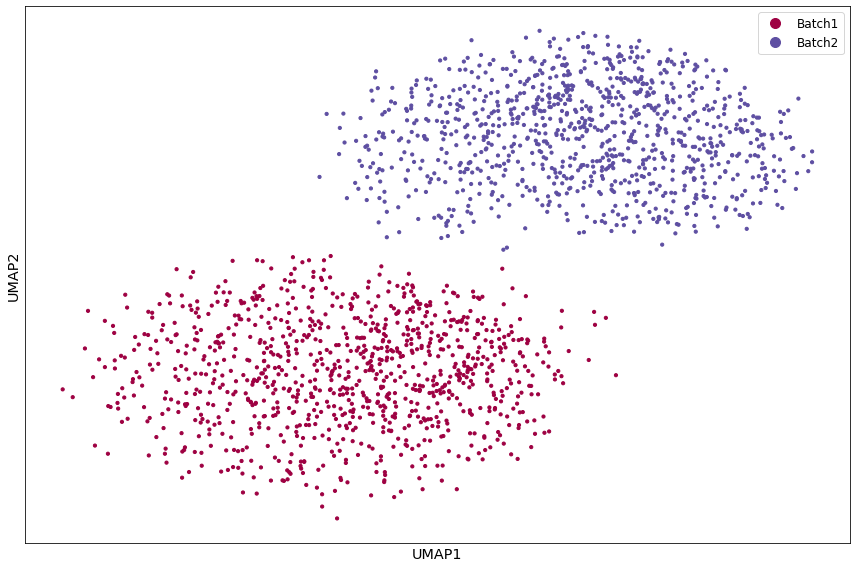

In [ ]:
scprep.plot.scatter2d(adata_umap0, c=adata.obs['Batch'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="UMAP", s = 10)

# AWGAN

In [ ]:
adata = imap.stage1.data_preprocess(adata, key='Batch', flavor='seurat')

Establishing Adata for Next Step...


... storing 'Batch' as categorical


PreProcess Done.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
adata.obs['batch'] = adata.obs['Batch'].copy()

Trying to set attribute `.obs` of view, copying.


In [ ]:
#calculate cos distence
@jit(nopython=True)
def pdist(vec1,vec2):
  return np.dot(vec1,vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
#calculate correlation index
@jit(nopython=True)
def find_correlation_index(frame1, frame2):
  result=[(1,1) for _ in range(len(frame2))]
  for i in range(len(frame2)):
    max_dist = -10
    it1=0
    it2=0
    for j in range(len(frame1)):
      dist = pdist(frame2[i],frame1[j])
      if dist>max_dist:
        max_dist = dist
        it1 = i
        it2 = j 
    result[i] = (it1, it2)
  return result

In [ ]:
# A new approach to get the index, what is faster based on our research.
def find_correlation_index(frame1, frame2):
  distlist =  cdist(frame2,frame1,metric='cosine')
  result = np.argmin(distlist,axis=1)
  result2 = []
  for i in range(len(frame2)):
    result2.append((i,result[i]))
  return result2

In [ ]:
def training_set_generator(frame1,frame2,ref,batch):
  common_pair = find_correlation_index(frame1,frame2)
  result = []
  result1 = []
  for i in common_pair:
    result.append(ref[i[1],:])
    result1.append(batch[i[0],:])
  return np.array(result),np.array(result1)

In [ ]:
class Mish(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return x*torch.tanh(F.softplus(x))

In [ ]:
#WGAN model, and it does not need to use bath normalization based on WGAN paper.
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.dis = nn.Sequential(
            nn.Linear(2000, 1024),  
            #nn.BatchNorm1d(1024),
            Mish(),
            nn.Linear(1024, 512),  
            #nn.BatchNorm1d(512),
            Mish(),
            nn.Linear(512, 256),  
            #nn.BatchNorm1d(256),
            Mish(),
            nn.Linear(256, 128),  
            #nn.BatchNorm1d(128),
            Mish(),
            nn.Linear(128, 1)

        )

    def forward(self, x):
        x = self.dis(x)
        return x
 
 
# WGAN generator
# Require batch normalization
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.relu_l = nn.ReLU(True)
        self.gen = nn.Sequential(
         
            nn.Linear(2000, 1024), 
            nn.Dropout(0.5), 
            nn.BatchNorm1d(1024, eps = 1e-7, momentum=0.01),
            Mish(),

            nn.Linear(1024, 512),  
            nn.BatchNorm1d(512, eps = 1e-7, momentum=0.01),
            Mish(),

            nn.Linear(512, 256),  
            nn.BatchNorm1d(256, eps = 1e-7, momentum=0.01),
            Mish(),

            nn.Linear(256, 512),  
            nn.BatchNorm1d(512, eps = 1e-7, momentum=0.01),
            Mish(),
  

            nn.Linear(512, 1024),  
            nn.BatchNorm1d(1024, eps = 1e-7, momentum=0.01),
            Mish(),

            nn.Linear(1024, 2000),
            nn.Dropout(0.5) 
           
        )

    def forward(self, x):
        gre = self.gen(x)
        return self.relu_l(gre+x)    #residual network
 
 
#Create object
D = discriminator()
G = generator()

if torch.cuda.is_available():
  D = D.cuda()
  G = G.cuda()

In [ ]:
# calculate gradient penalty
def calculate_gradient_penalty(real_data, fake_data, D): 
  eta = torch.FloatTensor(real_data.size(0),1).uniform_(0,1) 
  eta = eta.expand(real_data.size(0), real_data.size(1)) 
  cuda = True if torch.cuda.is_available() else False 
  if cuda: 
    eta = eta.cuda() 
  else: 
    eta = eta 
  interpolated = eta * real_data + ((1 - eta) * fake_data) 
  if cuda: 
    interpolated = interpolated.cuda() 
  else: 
    interpolated = interpolated 
   # define it to calculate gradient 
  interpolated = Variable(interpolated, requires_grad=True) 
   # calculate probability of interpolated examples 
  prob_interpolated = D(interpolated) 
  # calculate gradients of probabilities with respect to examples 
  gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated, 
  grad_outputs=torch.ones( 
  prob_interpolated.size()).cuda() if cuda else torch.ones( 
  prob_interpolated.size()), 
  create_graph=True, retain_graph=True)[0] 
  grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() 
  return grad_penalty

In [ ]:
# parameters
EPOCH = 150
# MAX_ITER = train_data.shape[0]
batch = 5
b1 = 0.9
b2 = 0.999
lambda_1 = 10

In [ ]:
d_optimizer = torch.optim.AdamW(D.parameters(), lr=0.0001)
g_optimizer = torch.optim.AdamW(G.parameters(), lr=0.0001)

In [ ]:
@jit(nopython = True)
def determine_batch(val1):
  val_list =[20,32,40,52,64,128,256]
  for i in val_list:
    if val1%i !=1:
      return i
    else:
      continue
  return val1

In [ ]:

def WGAN_train_type1(train_label,train_data,epoch,batch,lambda_1):
      stop = 0
  iter = 0
  D = discriminator()
  G = generator()

  if torch.cuda.is_available():
    D = D.cuda()
    G = G.cuda()
  lr=0.0001

  d_optimizer = torch.optim.AdamW(D.parameters(), lr=lr)
  g_optimizer = torch.optim.AdamW(G.parameters(), lr=lr)  

  G.train()
  D.train()

  MAX_ITER = train_data.shape[0]
  batch = determine_batch(MAX_ITER)

  for epoch_1 in range(epoch):
    print("This is ", epoch_1)
    for time in range(0,MAX_ITER,batch):
      true_data = torch.FloatTensor(train_label[time:time+batch,:]).cuda()
      false_data = torch.FloatTensor(train_data[time:time+batch,:]).cuda()
    

      #train d at first

      d_optimizer.zero_grad()

      real_out = D(true_data)
      real_label_loss = -torch.mean(real_out)

      # err_D.append(real_label_loss.cpu().float())

      # train use WGAN

      fake_out_new = G(false_data).detach()
      fake_out = D(fake_out_new)

      div = calculate_gradient_penalty(true_data, fake_out_new, D)

      label_loss = real_label_loss+torch.mean(fake_out)+div/lambda_1
      label_loss.backward()

      # err_D.append(label_loss.cpu().item())

      d_optimizer.step()
      # scheduler_D.step()
  
      #train G

      real_out = G(false_data)
      real_output = D(real_out)

      real_loss1 = -torch.mean(real_output)
      # err_G.append(real_loss1.cpu().item())

      g_optimizer.zero_grad()

      real_loss1.backward()
      g_optimizer.step()
      # scheduler_G.step()

      if(time%100==0):
        print("g step loss",real_loss1)
      iter += 1
  print("Train step finished")
  G.eval()
  test_data = torch.FloatTensor(train_data).cuda()
  test_list = G(test_data).detach().cpu().numpy()    
  return test_list,G

def WGAN_train_type2(train_label,train_data,epoch,batch,lambda_1):
      stop = 0
  iter = 0
  D = discriminator()
  G = generator()

  if torch.cuda.is_available():
    D = D.cuda()
    G = G.cuda()
  lr=0.0001

  d_optimizer = torch.optim.AdamW(D.parameters(), lr=lr)
  g_optimizer = torch.optim.AdamW(G.parameters(), lr=lr)  

  G.train()
  D.train()

  MAX_ITER = train_data.shape[0]
  batch = determine_batch(MAX_ITER)

  for epoch_1 in range(epoch):
    print("This is ", epoch_1)
    for time in range(0,MAX_ITER,batch):
      true_data = torch.FloatTensor(train_label[time:time+batch,:]).cuda()
      false_data = torch.FloatTensor(train_data[time:time+batch,:]).cuda()
    

      #train d at first

      d_optimizer.zero_grad()

      real_out = D(true_data)
      real_label_loss = -torch.mean(real_out)

      # err_D.append(real_label_loss.cpu().float())

      # train use WGAN

      fake_out_new = G(false_data).detach()
      fake_out = D(fake_out_new)

      div = calculate_gradient_penalty(true_data, fake_out_new, D)

      label_loss = real_label_loss+torch.mean(fake_out)+div/lambda_1
      label_loss.backward()

      # err_D.append(label_loss.cpu().item())

      d_optimizer.step()
      # scheduler_D.step()
  
      #train G

      real_out = G(false_data)
      real_output = D(real_out)

      real_loss1 = -torch.mean(real_output)
      # err_G.append(real_loss1.cpu().item())

      g_optimizer.zero_grad()

      real_loss1.backward()
      g_optimizer.step()
      # scheduler_G.step()

      if(time%100==0):
        print("g step loss",real_loss1)
      iter += 1
  print("Train step finished")
  G.eval()
  test_data = torch.FloatTensor(train_data).cuda()
  test_list = G(test_data).detach().cpu().numpy()    
  return test_list,G

def sequencing_train(ref_adata, batch_adata, batch_inf, epoch=100, batch=32, lambda_1=1/10, type_key=1):
      ref_data_ori = ref_adata.X
  for bat_inf in batch_inf[1:]:
    print("##########################Training%s#####################"%(bat_inf))
    batch_data_ori = batch_adata[batch_adata.obs['batch'] == bat_inf].X
    label_data,train_data = training_set_generator(ref_data_ori, batch_data_ori, ref_data_ori, batch_data_ori)
    print("#################Finish Pair finding##########################")
    if type_key==1:
      remove_batch_data,G_tar = WGAN_train_type1(label_data,train_data,epoch,batch,lambda_1)
    else:
      remove_batch_data,G_tar = WGAN_train_type2(label_data,train_data,epoch,batch,lambda_1)   
    ref_data_ori = np.vstack([ref_data_ori,remove_batch_data])
  print("###################### Finish Training ###########################")
  return ref_data_ori, G_tar

In [ ]:
ref_adata = adata[adata.obs['batch'] == adata.obs['batch'][0]]

batch_adata = adata[adata.obs['batch'] != adata.obs['batch'][0]]

In [ ]:
c=Counter(adata.obs['batch'])
c=dict(c)

In [ ]:
data,G_new = sequencing_train(ref_adata,batch_adata,batch_inf=list(c.keys()))

##########################Training:Batch2#####################
#################Finish Pair finding##########################
This is  0
g step loss tensor(0.0678, device='cuda:0', grad_fn=<NegBackward>)
g step loss tensor(-0.0900, device='cuda:0', grad_fn=<NegBackward>)
g step loss tensor(-0.6795, device='cuda:0', grad_fn=<NegBackward>)
g step loss tensor(-2.3514, device='cuda:0', grad_fn=<NegBackward>)
g step loss tensor(-5.4616, device='cuda:0', grad_fn=<NegBackward>)
g step loss tensor(-6.6467, device='cuda:0', grad_fn=<NegBackward>)
g step loss tensor(-6.0570, device='cuda:0', grad_fn=<NegBackward>)
g step loss tensor(-4.6155, device='cuda:0', grad_fn=<NegBackward>)
g step loss tensor(-2.7026, device='cuda:0', grad_fn=<NegBackward>)
g step loss tensor(-0.7802, device='cuda:0', grad_fn=<NegBackward>)
This is  1
g step loss tensor(-0.2021, device='cuda:0', grad_fn=<NegBackward>)
g step loss tensor(-0.1564, device='cuda:0', grad_fn=<NegBackward>)
g step loss tensor(0.2340, device='cu

In [ ]:
adata_new = sc.AnnData(data)
adata_new.obs['batch'] = np.array(list(adata.obs['batch']))

In [ ]:
data_umap0 = umap.UMAP().fit_transform(adata_new.X)

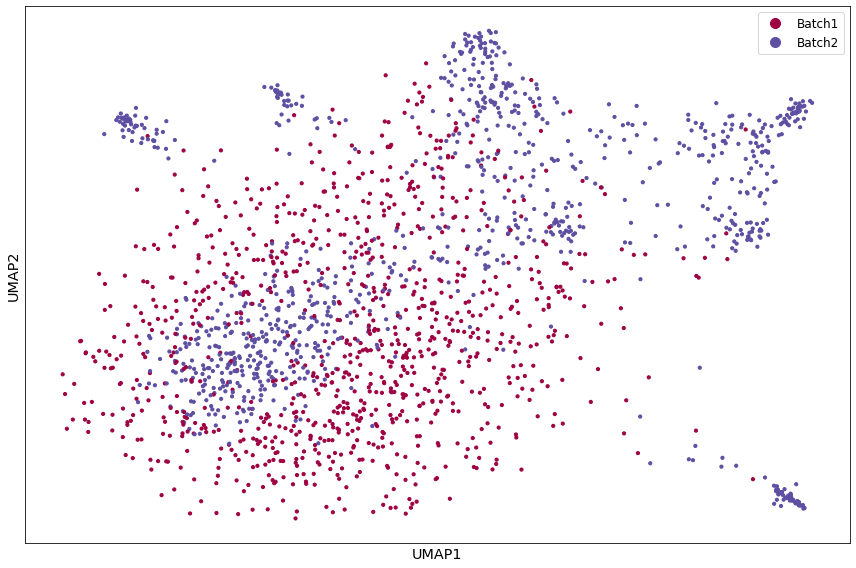

In [ ]:
scprep.plot.scatter2d(data_umap0, c=adata.obs['Batch'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="UMAP", s = 10)

In [ ]:
adata_new.write_loom('Simulate_gold.loom')